In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')   # suppress warnings

#### Data

In [2]:
# train data
df_train = pd.read_csv('Train.csv')
print(df_train.shape)
df_train.head()

(10001, 4)


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [3]:
# test data
df_test = pd.read_csv('Test.csv')
print(df_test.shape)
df_test.head()

(5177, 2)


,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


### Characteristics

In [4]:
# information 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [5]:
# check for missing values
df_test.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [6]:
# fill the missing values

##### train data

In [7]:
# fill missing values
# label and aggreement are floating numbers, use mean and round
cols = ['label', 'agreement']
for col in cols:
    print(f'Column: {col}')
    mean_rounded = round(df_train[col].mean())
    print(f'Mean round: {mean_rounded}')
    df_train[col].fillna(mean_rounded, inplace=True)

Column: label
Mean round: 0
Column: agreement
Mean round: 1


In [8]:
# there are some inconsistencies, label values should either be 1, 0, -1

# Check the values in the target variable and handle any inconsistencies
df_train['label'] = df_train['label'].round().astype(int)

# Verify the counts of the target variable after handling inconsistencies
label_counts = df_train['label'].value_counts()
print(label_counts)

label
 0    4909
 1    4054
-1    1038
Name: count, dtype: int64


#### Further preprocessing

##### Handle texts

In [9]:
# importing libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [11]:
# downloading nltk resources
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [12]:
# initialize wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
# Tokenization, lowercasing, removal of stop words, and lemmatization
# function to preprocess texts
def preprocess_text(text):
    # tokenization
    tokens = word_tokenize(text)

    # lowercasing
    tokens = [token.lower() for token in tokens]

    # removal of punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # removal of stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Example text
text = "This is an example sentence for text preprocessing, including tokenization, lowercasing, stop word removal, and lemmatization."

# Preprocess the example text
preprocessed_text = preprocess_text(text)
print("Original Text:")
print(text)
print("\nPreprocessed Text:")
print(preprocessed_text)

Original Text:
This is an example sentence for text preprocessing, including tokenization, lowercasing, stop word removal, and lemmatization.

Preprocessed Text:
example sentence text preprocessing including tokenization lowercasing stop word removal lemmatization


In [14]:
# preprocess texts in 'safe_text' column in train data
df_train['safe_text'] = df_train['safe_text'].apply(preprocess_text)

In [15]:
# Convert 'safe_text' column to strings
df_test['safe_text'] = df_test['safe_text'].astype(str)

# preprocess texts in 'safe_text' column in test_data
df_test['safe_text'] = df_test['safe_text'].apply(preprocess_text)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve

In [17]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = vectorizer.fit_transform(df_train['safe_text'])
X_test_text = vectorizer.transform(df_test['safe_text'])

In [18]:
# Combine text features with selected numerical features
X_train_num = df_train.drop(columns=['label', 'agreement', 'tweet_id'])
X_test_num = df_test.drop(columns=['tweet_id'])
X_train = pd.concat([X_train_num, pd.DataFrame(X_train_text.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)
X_test = pd.concat([X_test_num, pd.DataFrame(X_test_text.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)

In [21]:
# Remove non-numeric columns before feature selection
X_train_numeric = X_train.select_dtypes(include=['float64'])
X_test_numeric = X_test.select_dtypes(include=['float64'])

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=23)
X_train_selected = selector.fit_transform(X_train_numeric, df_train['label'])
X_test_selected = selector.transform(X_test_numeric)

In [22]:
# Split data into training and testing sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_selected, df_train['label'], test_size=0.2, random_state=42)

In [23]:
# handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# Handle class imbalance
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_final, y_train_final)

In [25]:
# Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [26]:
# Model Evaluation
y_pred_val = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy*100)
print("Classification Report:")
print(classification_report(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

Validation Accuracy: 62.118940529735134
Classification Report:
              precision    recall  f1-score   support

          -1       0.29      0.27      0.28       231
           0       0.72      0.70      0.71       988
           1       0.59      0.63      0.61       782

    accuracy                           0.62      2001
   macro avg       0.54      0.53      0.53      2001
weighted avg       0.62      0.62      0.62      2001

Confusion Matrix:
[[ 63  66 102]
 [ 61 689 238]
 [ 91 200 491]]


In [27]:
# function check for overfitting or underfitting
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    # Check for overfitting or underfitting
    diff_scores = train_scores_mean - test_scores_mean
    if np.any(diff_scores > 0):
        print("Yes, overfitting")
    elif np.any(diff_scores < 0):
        print("Yes, underfitting")
    else:
        print("No overfitting or underfitting")
    
    return plt

Yes, overfitting


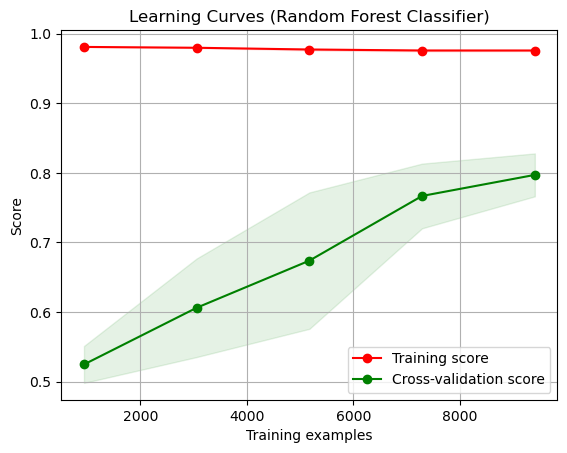

In [28]:
# Learning Curve
title = "Learning Curves (Random Forest Classifier)"
plot_learning_curve(rf_model, title, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
plt.show()

In [29]:
# Make predictions on test data and create submission DataFrame
test_predictions = rf_model.predict(X_test_selected)
submission_df = pd.DataFrame({'tweet_id': df_test['tweet_id'], 'label': test_predictions})
submission_df.to_csv('submission_rf.csv', index=False)